# Imports

In [2]:
import json
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Download the data

In [4]:
# Download the dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

# Process the data

In [5]:
# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [7]:
sentences[:3]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild"]

In [8]:
labels[:3]

[0, 0, 1]

# Split the dataset

In [9]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Output dimensions of the Embedding layer
EMBEDDING_DIM = 16

In [10]:
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

In [12]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                                    output_sequence_length=MAX_LENGTH)

vectorize_layer.adapt(train_sentences)

In [13]:
train_sequences = vectorize_layer(train_sentences)
test_sequences = vectorize_layer(test_sentences)

In [14]:
train_sequences[0]

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 319,    1,  943, 4079, 2366,   47,  366,   94, 2026,    6, 2653,
       9470,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [45]:
train_dataset_vectorized = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

# Build and compile the model

In [48]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,433 (626.69 KB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the model

In [50]:
NUM_EPOCHS = 10

history = model.fit(train_dataset_final,
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset_final,
                    verbose=2)

Epoch 1/10
625/625 - 2s - 4ms/step - accuracy: 0.6732 - loss: 0.5889 - val_accuracy: 0.8088 - val_loss: 0.4385
Epoch 2/10
625/625 - 1s - 2ms/step - accuracy: 0.8543 - loss: 0.3557 - val_accuracy: 0.8444 - val_loss: 0.3657
Epoch 3/10
625/625 - 1s - 2ms/step - accuracy: 0.8910 - loss: 0.2752 - val_accuracy: 0.8506 - val_loss: 0.3493
Epoch 4/10
625/625 - 1s - 2ms/step - accuracy: 0.9129 - loss: 0.2254 - val_accuracy: 0.8520 - val_loss: 0.3550
Epoch 5/10
625/625 - 1s - 2ms/step - accuracy: 0.9272 - loss: 0.1933 - val_accuracy: 0.8314 - val_loss: 0.4116
Epoch 6/10
625/625 - 1s - 2ms/step - accuracy: 0.9356 - loss: 0.1705 - val_accuracy: 0.8493 - val_loss: 0.3875
Epoch 7/10
625/625 - 1s - 2ms/step - accuracy: 0.9438 - loss: 0.1504 - val_accuracy: 0.8447 - val_loss: 0.4135
Epoch 8/10
625/625 - 1s - 2ms/step - accuracy: 0.9517 - loss: 0.1325 - val_accuracy: 0.8249 - val_loss: 0.5003
Epoch 9/10
625/625 - 1s - 2ms/step - accuracy: 0.9574 - loss: 0.1204 - val_accuracy: 0.8393 - val_loss: 0.4623
E

# Visualize the results

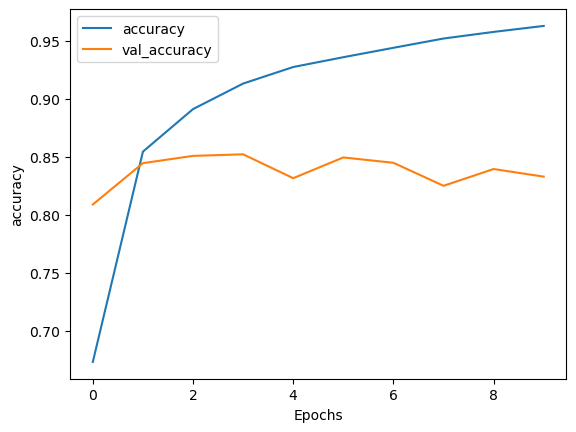

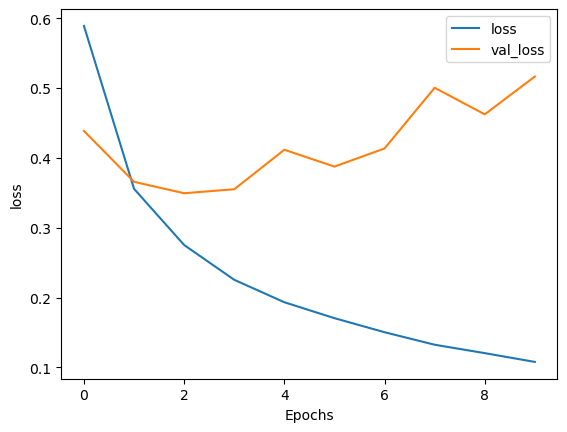

In [52]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")